# Max-Cut and Traveling Salesman Problem

## Introduction

Many problems in quantitative fields such as finance and engineering are optimization problems. Optimization problems lie at the core of complex decision-making and definition of strategies. 

Optimization (or combinatorial optimization) means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called cost function or objective function. 

**Typical optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects 

We consider here max-cut problems of practical interest in many fields, and show how they can be mapped on quantum computers manually and how Qiskit optimization module supports this.


### Weighted Max-Cut

Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other's buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.

The formal definition of this problem is the following:

Consider an $n$-node undirected graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(i, j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)

$$\tilde{C}(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j).$$

In our simple marketing model, $w_{ij}$ represents the probability that the person $j$ will buy a product after $i$ gets a free one. Note that the weights $w_{ij}$ can in principle be greater than $1$ (or even negative), corresponding to the case where the individual $j$ will buy more than one product. Maximizing the total buying probability corresponds to maximizing the total future revenues. In the case where the profit probability will be greater than the cost of the initial free samples, the strategy is a convenient one. An extension to this model has the nodes themselves carry weights, which can be regarded, in our marketing model, as the likelihood that a person granted with a free sample of the product will buy it again in the future. With this additional information in our model, the objective function to maximize becomes 

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j)+\sum_i w_i x_i. $$
 
In order to find a solution to this problem on a quantum computer, one needs first to map it to an Ising Hamiltonian. This can be done with the assignment $x_i\rightarrow (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$. Doing this we find that 

$$C(\textbf{Z}) = \sum_{i,j} \frac{w_{ij}}{4} (1-Z_i)(1+Z_j) + \sum_i \frac{w_i}{2} (1-Z_i) = -\frac{1}{2}\left( \sum_{i<j} w_{ij} Z_i Z_j +\sum_i w_i Z_i\right)+\mathrm{const},$$

where $\mathrm{const} = \sum_{i<j}w_{ij}/2+\sum_i w_i/2$. In other terms, the weighted Max-Cut problem is equivalent to minimizing the Ising Hamiltonian 

$$ H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j.$$

Qiskit optimization module can generate the Ising Hamiltonian for the first profit function $\tilde{C}$.
To this extent, function $\tilde{C}$ can be modeled as a `QuadraticProgram`, which provides the `to_ising()` method.


### Approximate Universal Quantum Computing for Optimization Problems

There has been a considerable amount of interest in recent times about the use of quantum computers to find a solution to combinatorial optimization problems. It is important to say that, given the classical nature of combinatorial problems, exponential speedup in using quantum computers compared to the best classical algorithms is not guaranteed. However, due to the nature and importance of the target problems, it is worth investigating heuristic approaches on a quantum computer that could indeed speed up some problem instances. Here we demonstrate an approach that is based on the *Quantum Approximate Optimization Algorithm* (QAOA) by Farhi, Goldstone, and Gutmann (2014). We frame the algorithm in the context of *approximate quantum computing*, given its heuristic nature. 

The algorithm works as follows:

1. Choose the $w_i$ and $w_{ij}$ in the target Ising problem. In principle, even higher powers of Z are allowed.

1. Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.

1. Choose a set of controls $\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$. 

1. Evaluate 
$$C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H|~\psi(\boldsymbol\theta)\rangle = \sum_i w_i \langle\psi(\boldsymbol\theta)~|Z_i|~\psi(\boldsymbol\theta)\rangle+ \sum_{i<j} w_{ij} \langle\psi(\boldsymbol\theta)~|Z_iZ_j|~\psi(\boldsymbol\theta)\rangle$$ 
by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen. 

1. Use a classical optimizer to choose a new set of controls.

1. Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.

1. Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $|\langle z_i~|\psi(\boldsymbol\theta)\rangle|^2\;\forall i$ to obtain the answer.
    
It is our belief the difficulty of finding good heuristic algorithms will come down to the choice of an appropriate trial wavefunction. For example, one could consider a trial function whose entanglement best aligns with the target problem, or simply make the amount of entanglement a variable. In this tutorial, we will consider a simple trial function of the form

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of quantum states that have only real coefficients, still exploiting the entanglement to potentially converge faster to the solution.

One advantage of using this sampling method compared to adiabatic approaches is that the target Ising Hamiltonian does not have to be implemented directly on hardware, allowing this algorithm not to be limited to the connectivity of the device. Furthermore, higher-order terms in the cost function, such as $Z_iZ_jZ_k$, can also be sampled efficiently, whereas in adiabatic or annealing approaches they are generally impractical to deal with. 


References:

- \ A. Lucas, Frontiers in Physics 2, 5 (2014)
- \ E. Farhi, J. Goldstone, S. Gutmann, e-print arXiv 1411.4028 (2014)
- \ D. Wecker, M. B. Hastings, M. Troyer, Phys. Rev. A 94, 022309 (2016)
- \ E. Farhi, J. Goldstone, S. Gutmann, H. Neven, e-print arXiv 1703.06199 (2017)

### Application classes

We use the application classes for the max-cut problem and the traveling salesman problem in this page. There are application classes for other optimization problems available as well.
See [Application Classes for Optimization Problems](09_application_classes.ipynb) for details.

In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

## Max-Cut problem

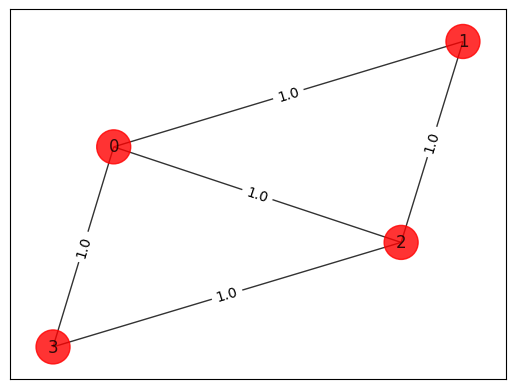

In [2]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Brute force approach

Try all possible $2^n$ combinations. For $n = 4$, as in this example, one deals with only 16 combinations, but for n = 1000, one has 1.071509e+30 combinations, which is impractical to deal with by using a brute force approach. 

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


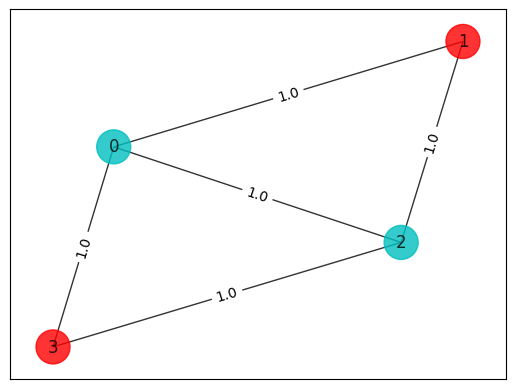

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

### Mapping to the Ising problem

Qiskit optimization provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.


In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [6]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [7]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


Since the problem was cast to a minimization problem, the solution of $-4$ corresponds to the optimum.

### Checking that the full Hamiltonian gives the right cost 

energy: -1.5
max-cut objective: -4.0
solution: [1. 0. 1. 0.]
solution objective: 4.0


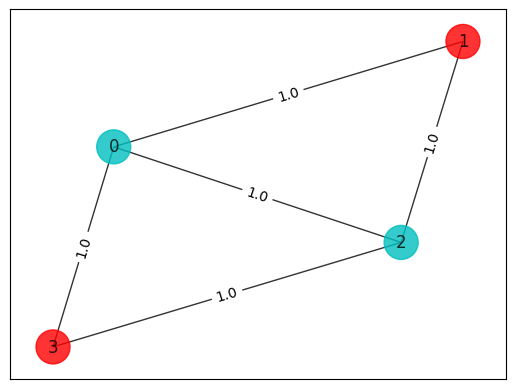

In [8]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [9]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -1.4996861455587294
time: 2.7263295650482178
max-cut objective: -3.999686145558729
solution: [0 1 0 1]
solution objective: 4.0


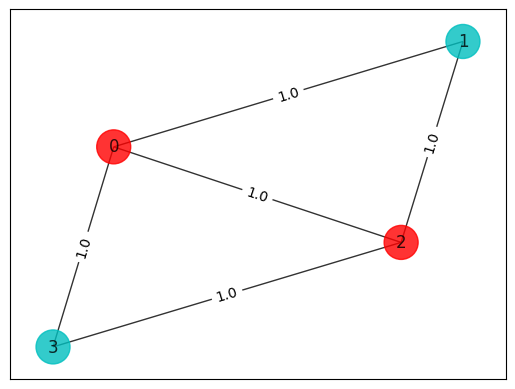

In [10]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


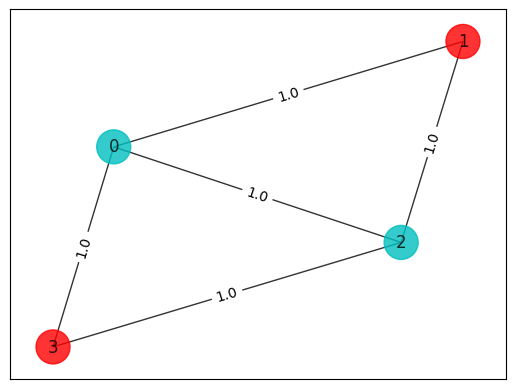

In [11]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## Traveling Salesman Problem

In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time. 

The problem derives its importance from its "hardness" and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.
 
The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest *Hamiltonian cycle* that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and $p$ represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summands run over 0,1,...N-1)

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j) \notin E$ (not connected in the graph). The form of this penalty is 

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$ 

where it is assumed the boundary condition of the Hamiltonian cycles $(p=N)\equiv (p=0)$. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

Putting this all together in a single objective function to be minimized, we get the following:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ is a free parameter. One needs to ensure that $A$ is large enough so that these constraints are respected. One way to do this is to choose $A$ such that $A > \mathrm{max}(w_{ij})$.

Once again, it is easy to map the problem in this form to a quantum computer, and the solution will be found by minimizing a Ising Hamiltonian. 

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


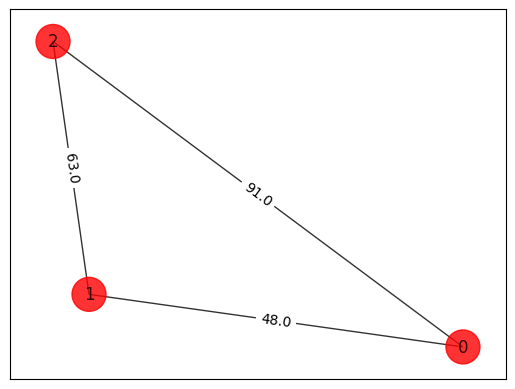

In [12]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

### Brute force approach

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


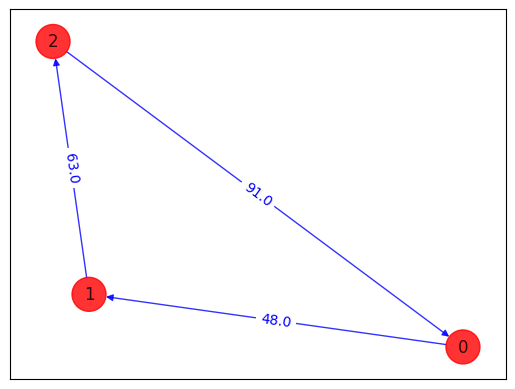

In [13]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

### Mapping to the Ising problem

In [14]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [15]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIIZZI', 'IIIIIZIIZ', 'IIIIIZIZI', 'IIIIIZZII', 'IIIIZIIIZ', 'IIIIZIIZI', 'IIIIZIZII', 'IIIIZZIII', 'IIIZIIIIZ', 'IIIZIIIZI', 'IIIZIIZII', 'IIIZIZIII', 'IIIZZIIII', 'IIZIIIIIZ', 'IIZIIIIZI', 'IIZIIIZII', 'IIZIIZIII', 'IIZIZIIII', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIIZI', 'IZIIIIZII', 'IZIIIZIII', 'IZIIZIIII', 'IZIZIIIII', 'IZZIIIIII', 'ZIIIIIIIZ', 'ZIIIIIIZI', 'ZIIIIIZII', 'ZIIIIZIII', 'ZIIIZIIII', 'ZIIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,
    12.  +0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,    12.  +0.j,
    12.  +0.j,   606.5 +0.j,   606.5 +0.j,   606.5 +0.j,   6

In [16]:
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost 

energy: -7379.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


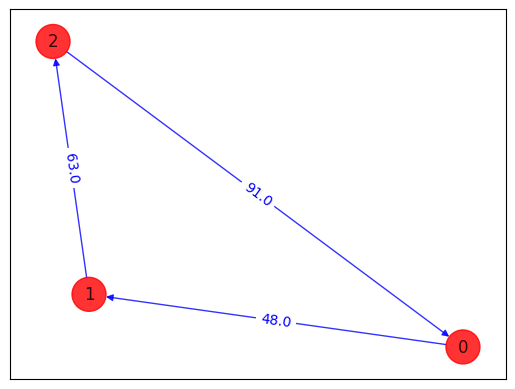

In [17]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [18]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -7326.02469952184
time: 13.816433191299438
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


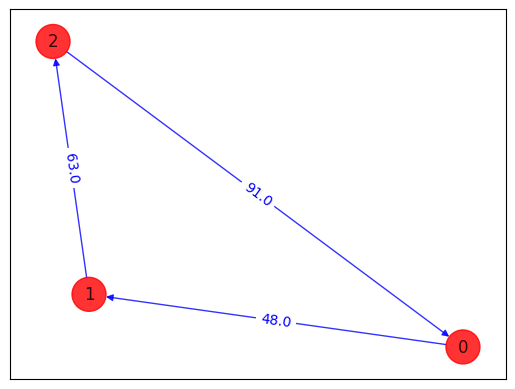

In [19]:
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [20]:
algorithm_globals.random_seed = 123
seed = 10598

objective function value: 202.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0
status: SUCCESS
solution: [1, 2, 0]
solution objective: 202.0


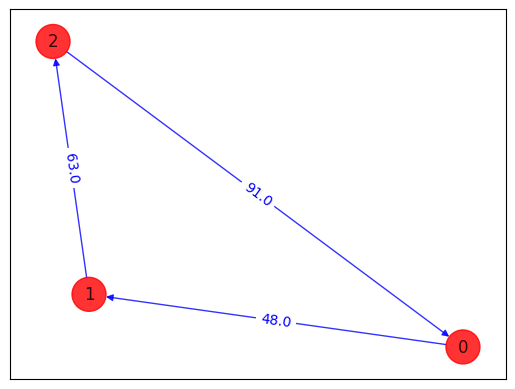

In [21]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [22]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright